# Helmholtz 1D: Building The Multilevel Hierarchy, Step-by-Step
* Discretization: 5-point (4th order).
* Fixed-domain problem; non-repetitive, so we generate TVs over entire domain.
* Fix aggregate size to $4$ points. Consider a certain aggregate in the domain (say, the first one).
* Observe beahviour vs. $\nu$:
  * Create relaxed TVs with $\nu$ Kaczmarz relaxation sweeps.
  * Create the coarsening operator $R$ using SVD. Observe singular value decay rate.
  * Observe two-level mini-cycle convergence factor before slowing down.

## Shrinkage Factor
Given an iterative method, we can calculate whether it's a good smoothing candidate using the **shrinkage factor** $\mu$, even before measuring its mock cycle rate (which measures the combination of the smoother andcoarsening operator $R$).

* Start from $5$ different random starts $x_0 = rand[-1,1]$, for each  apply the method for $A x = 0$ to obtain iterates $x_1, x_2, \dots$.
* For each iterate, calculate residual norm $r_i := \|A x_i\|_2$ and reduction per sweep, $\mu_i := (r_i / r_0)^{\frac{1}{i}}$, $i = 1, 2, \dots$.
* Average $\mu_i$ over the $5$ starts.
* Terminate the method at $j = i + 3$, where $i = argmin_i \mu_i$ and set $\mu \leftarrow \mu_j$.

In [1]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

logger = logging.getLogger("main")
_LOGGER = logger

In [2]:
def check_coarsening(level, aggregate_size: int = 4):
    """Checks coarsening based on relaxed TVs, for different number of relaxation sweeps.
    If aggregate_size is not None, forces that aggregate size for the entire domain."""
    num_sweeps_values = 5 * 2 ** np.arange(8)

    fig, axs = plt.subplots(len(num_sweeps_values), 3, figsize=(16, 3 * len(num_sweeps_values)))
    for row, num_sweeps in enumerate(num_sweeps_values):
        # Create relaxed TVs.
        x = hm.solve.run.run_iterative_method(
            level.operator, lambda x: level.relax(x, b), x_random, num_sweeps=num_sweeps)[0]

        start, end = 0, aggregate_size
        x_aggregate_t = x[start:end].transpose()
        r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
        r = r.asarray()

        # Relaxed vectors.
        ax = axs[row, 0]
        for i in range(3):
            ax.plot(x[:, i]);
        ax.grid(True)
        ax.set_title(r"Test Vectors, $\nu={}$ sweeps".format(num_sweeps))

        ax = axs[row, 1]
        # R should be real-valued, but cast just in case.
        for i, ri in enumerate(np.real(r)):
            ax.plot(ri)
        ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
        ax.set_ylabel(r"$R$ rows")
        ax.grid(True);

        # Singular values, normalized to sigma_max = 1.
        ax = axs[row, 2]
        ax.plot(s / s[0], "rx")
        ax.set_title("Singular Values")
        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"$\sigma_k$")
        ax.grid(True);

        print("nu", "{:2d}".format(num_sweeps), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

        # Generate coarse variables (R) on the non-repetitive domain.
        r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x, threshold=threshold,
                                                                                           fixed_aggregate_size=aggregate_size)
        _LOGGER.info("Agg {}".format(np.array([len(aggregate) for aggregate in aggregates])))
        _LOGGER.info("nc  {}".format(nc))
        _LOGGER.info("Energy error mean {:.4f} max {:.4f}".format(np.mean(energy_error), np.max(energy_error)))
        mock_conv_factor = np.array(
            [hm.setup.auto_setup.mock_cycle_conv_factor(level, r, nu) for nu in np.arange(1, 16, dtype=int)])
        _LOGGER.info("Mock cycle conv factor {}".format(np.array2string(mock_conv_factor, precision=3)))

In [3]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

# Number of test vectors.
num_examples = 20
threshold = 0.1

# Boottstrapping parameters.
threshold = 0.1
interpolation_method = "ls"
num_test_examples = 5

## Level 0->1 Coarsening

### Relaxation Shrinkage Factor

kh 0
INFO     Iter     |r|                         |x|         RER
INFO     0     1.442e+00                    4.470e-01    3.223
INFO     1     7.733e-01 (0.537) [0.537]    3.302e-01    2.352 (0.728)
INFO     2     4.380e-01 (0.567) [0.552]    2.782e-01    1.591 (0.675)
INFO     3     2.670e-01 (0.611) [0.571]    2.529e-01    1.071 (0.673)
INFO     4     1.782e-01 (0.668) [0.594]    2.386e-01    0.759 (0.709)
INFO     5     1.313e-01 (0.737) [0.620]    2.293e-01    0.581 (0.767)
INFO     6     1.053e-01 (0.802) [0.648]    2.225e-01    0.480 (0.827)
INFO     7     8.955e-02 (0.850) [0.673]    2.172e-01    0.417 (0.871)
INFO     8     7.901e-02 (0.881) [0.696]    2.128e-01    0.375 (0.900)
INFO     9     7.133e-02 (0.902) [0.717]    2.090e-01    0.344 (0.918)
INFO     10    6.539e-02 (0.915) [0.735]    2.057e-01    0.320 (0.930)
INFO     11    6.063e-02 (0.925) [0.750]    2.028e-01    0.301 (0.939)
INFO     12    5.665e-02 (0.932) [0.764]    2.002e-01    0.285 (0.945)
INFO     13    5.3

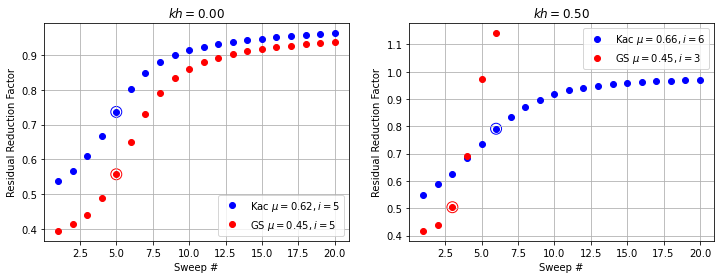

In [6]:
kh_values = [0, 0.5]
fig, axs = plt.subplots(1, len(kh_values), figsize=(12, 4))

kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

# Kaczmarz.
for kh_value, ax in zip(kh_values, axs):
    print("kh", kh_value)
    a_kh = hm.linalg.helmholtz_1d_5_point_operator(kh_value, n).tocsr()
    operator = lambda x: a_kh.dot(x)

    for title, relax, color in zip(("Kac", "GS"), (kaczmarz, gs), ("blue", "red")):
        method = relax(a_kh)
        factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
            operator, lambda x, b: method.step(x, b), (a_kh.shape[0], ), 
            print_frequency=1, max_sweeps=20, slow_conv_factor=1.1)
        hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
        print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} residual-per-sweep {:.2f}".format(
            title, np.mean(residual[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))
    
    ax.set_title(r"$kh = {:.2f}$".format(kh_value))
    ax.legend()

The point of diminishing returns in each scatterplot is circled.

This estimate seems to give a reasonable estimate for both $kh$ values and both relaxation schemes (albeit not a quantitative smoothing factor, which can only be defined based on a coarsening), showing that GS is a better smoother for both $kh = 0, 0.5$, but slightly diverges for $kh = 0.5$. The RER at the point of diminishing returns is much smaller.

Averaging over multiple random starts helps reduce noise, as well as assuming a constant reduction per sweep in the initial sweeps (as opposed to a linear model, say). We are only interested in a rough estimate.

### Coarsening Quality
We measure the gap between the second and third singular values as a function of the number of TV relaxation sweeps $\nu$. We force the aggregate size to be $4$.

In [ ]:
a = hm.linalg.helmholtz_1d_5_point_operator(kh, n).tocsr()
level = hm.setup.hierarchy.create_finest_level(a)
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

In [ ]:
check_coarsening(level, 4)

In [ ]:
check_coarsening(level, 6)

The gap $\sigma_2 - \sigma_3$ increases with $\nu$, showing that an aggregate size of $4$ is fine (we can obtain an energy error as small as we want given a large enough $\nu$).

### Two-level Bootstrapping

In [ ]:
max_levels = 2
num_bootstrap_steps = 1
num_sweeps = 10
fixed_aggregate_size = None # 6

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
x_log.append(x)

_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
        threshold=threshold, fixed_aggregate_size=fixed_aggregate_size)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

### Relaxation Cycle Shrinkage
We compare relaxation cycle with $\nu_1=2, \nu_2=2, \nu_{coarse}=20$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel, nu_coarsest=20)

Even though per work unit it is about the same (the mini-cycle is $6$ relaxations worth), the two-level relaxation cycle reduces the RER much more than Kaczmarz until the point of diminishing returns.

As expected, both methods are asymptotically slow (probably the same rate of convergence).

### Effect of a Second Bootstrap Cycle

In [ ]:
x, multilevel = hm.setup.auto_setup.bootstap(
    x, multilevel, num_levels, 2.0,
    num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
x_log.append(x)
r_log.append(multilevel.level[1].r)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel)

Looks like the final RER obtained with a relaxation cycle after one and two bootstrap cycles is the same, so we didn't make it worse.

### Effect of Bootstrap on $R$'s Singular Values

In [ ]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x_fit, threshold=threshold)
r_log.append(r)

In [ ]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

With bootstrap cycles, the smoother the TVs and the better the singular value separation: $R$ is improved.

In [ ]:
# Save fine-level TVs.
x_fine = x

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [ ]:
level = multilevel.level[1]
a = level.a
x_random = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
b = np.zeros_like(x_random)

### Relaxation Shrinkage Factor

In [ ]:
kaczmarz = lambda a: hm.solve.relax.KaczmarzRelaxer(a, scipy.sparse.eye(a.shape[0]))
gs = lambda a: hm.solve.relax.GsRelaxer(a)
work = 1

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Kaczmarz.
operator = lambda x: a.dot(x)
for title, relax, color in zip(("Kac", ), (kaczmarz, ), ("blue", )):
    method = relax(a)
    factor, num_sweeps, rer, conv = hm.solve.smoothing.shrinkage_factor(
        operator, lambda x, b: method.step(x, b), (a.shape[0], ), print_frequency=1, max_sweeps=20, slow_conv_factor=2, num_examples=1)
    hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
    print("{:<10s} RER at point of diminishing returns {:.2f} num_sweeps {:>2d} work {:>2d} RER-per-sweep {:.2f}".format(
        title, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(rer[num_sweeps] / rer[0]) ** (1/(num_sweeps * work))))

ax.set_title(r"$kh = {:.2f}$".format(kh_value))
ax.legend();

Kaczmarz slows down more quickly here than on level 1. GS diverges.

### $R$ for Aggregate Size = 4

In [ ]:
check_coarsening(level, 4)

It looks like it takes a lot more relaxation sweeps to see $2$ components in a size $4$ aggregate here. Mock cycle rates are also worse.

### $R$ for Aggregate Size = 6

In [ ]:
check_coarsening(level, 6)

One can obtain a good coarsening here too (in terms of coarsening ratio and mock cycle rates), with an aggregate size of $6$ and $3$ coarse variables. Note that this requires less smoothing ($\nu = 40$) than for an aggregate size of $4$, where we stll $3$ PCs until $\nu$ is much larger ($320$). Thus, a general criterion would find the larger aggregate size.

The mock cycle rates are worse than for level 0, but we can still obtain improvement when more relaxations per cycle are added. Convergence of $0.2$ is obtained for $11$ relaxations per cycle, as opposed to $3$ at level 0.

### $R$ with Dynamic Aggregate Size

In [ ]:
check_coarsening(level, None)

### Two-level Bootstrapping

In [ ]:
num_examples = 30
max_levels = 2
num_bootstrap_steps = 3
num_sweeps = 20

x_log = []
r_log = []

# Initialize hierarchy to 1-level and fine-level test functions to random.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel(level)

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))
_, relax_conv_factor = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), 
    hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples), num_sweeps=100)
_LOGGER.info("Relax convergence factor {:.3f}".format(relax_conv_factor))

# Start from random again. Level 0 doesn't exist here.
x = hm.solve.run.random_test_matrix((a.shape[0],), num_examples=num_examples)
x_log.append(x)

# Improve vectors with 1-level relaxation.
_LOGGER.info("Generating TVs with {} sweeps".format(num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(a.dot(x)) / norm(x)))
x_log.append(x)

# Bootstrap with an increasingly deeper hierarchy (add one level at a time).
num_levels = 2
_LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
_LOGGER.info("-" * 80)
for i in range(num_bootstrap_steps):
    _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
    # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
    x, multilevel = hm.setup.auto_setup.bootstap(
        x, multilevel, num_levels, 2.0,
        num_sweeps=num_sweeps, interpolation_method=interpolation_method, threshold=threshold)
    x_log.append(x)
    r_log.append(multilevel.level[1].r)
    _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
    _LOGGER.info("-" * 80)

In [ ]:
# Create a final R from the most updated TVs.
x_fit, x_test = x[:, :-num_test_examples], x[:, -num_test_examples:]

# Create the coarsening operator R.
r, aggregates, nc, energy_error = hm.setup.coarsening.create_coarsening_domain(x_fit, threshold=threshold)
r_log.append(r)

In [ ]:
aggregate_size = 4
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    start, end = 0, aggregate_size
    x_aggregate_t = x[start:end].transpose()
    r, s = hm.setup.coarsening.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

Here we also observe that the singular value gap increases with bootsrap cycles, but no longer monotonically (it is noisy).

In [ ]:
hm.solve.smoothing.check_relax_cycle_shrinkage(multilevel, max_sweeps=100)

## Questions
* Why aren't level 1 TVs getting smoother with bootstrap cycles? Their RER oscillates wildly between cycles even though the interpolation error is good (see cycle 2->3).
* Need a lot more examples (30 instead of 20) on level 1 because apparently there are up to 12 interpolation points in the stencil (if a large enough aggregate is chosen).